In [50]:
import pandas as pd
import os

expdirs = ['benchmarks_gpu_4']

master_df = pd.DataFrame(columns=["db", "ts", "gpu", "recall", "qps", "wspq", "point" ])

# iterate all experiments
for expdir in expdirs:
    
    # iterate each dbase in the experiment
    for dbdir in os.listdir(expdir):
        
        # parse the directory name for dbname and gpu status
        parts = dbdir.split('.')
        
#        print(parts)
        dbname = parts[1]
        print(dbname)
        gpu = int(parts[4].split('=')[1])
        ts = int(parts[5].split('=')[1])
        
        # filter experiments we don't care about
        if (dbname.find("1B")<0):
            print("skipping non 1B experiment", dbname)
            continue           
        
        # parse the main data file into a df
        expfile=os.path.join( expdir, dbdir, "data.txt")
        print("expfile",expfile)
        df = pd.read_csv(expfile, header=None)
        df.columns = [ "capts", "recall", "mspq", "mindur", "totpow", "totq", "wspq" ]   
        df = df.filter(items=[ "recall", "mspq", "wspq"])
 
        # get mspq, compute qps and add to df, remove mspq
        mspq = df['mspq'].tolist()
        qps = [ (1.0/t*1000.0) for t in mspq ]
        df['qps']= qps
        df.drop(columns=['mspq'])

        # add gpu usage to df
        df['gpu']=[gpu]*df.shape[0]

        # add dbname to df
        df['db']=[dbname]*df.shape[0]
        
        # add ts to df
        df['ts']=[ts]*df.shape[0]
        
        # add the point to the df
        df['point'] = range(0, df.shape[0])
        
        # accumulate to the master df
        master_df = master_df.append(df, ignore_index=True)
            
print(master_df)
print("There are %d rows" % master_df.shape[0])

bigann-1B
expfile benchmarks_gpu_4/run.bigann-1B.IVF1048576,SQ8.faissindex.gpu=1.time=1627090279.092506/data.txt
bigann-1B
expfile benchmarks_gpu_4/run.bigann-1B.IVF1048576,SQ8.faissindex.gpu=1.time=1627089961.409021/data.txt
text2image-1B
expfile benchmarks_gpu_4/run.text2image-1B.IVF1048576,SQ8.faissindex.gpu=1.time=1627088093.517202/data.txt
msspacev-1B
expfile benchmarks_gpu_4/run.msspacev-1B.IVF1048576,SQ8.faissindex.gpu=1.time=1627091173.222311/data.txt
msspacev-1B
expfile benchmarks_gpu_4/run.msspacev-1B.IVF1048576,SQ8.faissindex.gpu=1.time=1627090861.948962/data.txt
deep-1B
expfile benchmarks_gpu_4/run.deep-1B.IVF1048576,SQ8.faissindex.gpu=1.time=1627087481.534880/data.txt
text2image-1B
expfile benchmarks_gpu_4/run.text2image-1B.IVF1048576,SQ8.faissindex.gpu=1.time=1627088913.096689/data.txt
msturing-1B
expfile benchmarks_gpu_4/run.msturing-1B.IVF1048576,SQ8.faissindex.gpu=1.time=1627085207.088313/data.txt
msturing-1B
expfile benchmarks_gpu_4/run.msturing-1B.IVF1048576,SQ8.fais

               dbase                  QPS            recall@10
           bigann-1B          2186.754570             0.904860
           bigann-1B          1926.901416             0.911140
           bigann-1B          1657.226695             0.919860
           bigann-1B          2058.950046             0.926560
           bigann-1B          1931.042641             0.932450
           bigann-1B          1770.748406             0.937190
           bigann-1B          1609.052224             0.941330
           bigann-1B          1504.748288             0.943890
       text2image-1B          2607.779941             0.834820
       text2image-1B          2456.621393             0.841845
       text2image-1B          2285.966847             0.851920
       text2image-1B          2120.635218             0.860156
       text2image-1B          1917.445903             0.867244
       text2image-1B          1748.662912             0.873469
       text2image-1B          1612.313130             0

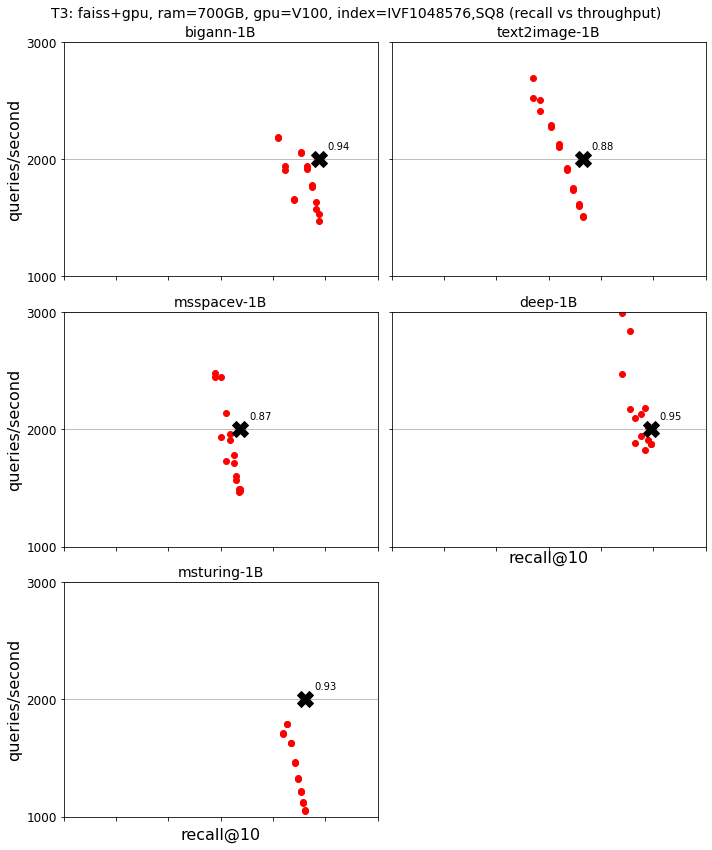

In [52]:
# Individual dbase plots
import numpy as np
from scipy import interpolate
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('axes', labelsize=16, titlesize=16)
import math
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams["figure.figsize"] = (10,12)
plt.rcParams["figure.titlesize"] = 14
plt.rcParams["figure.titleweight"] = 'roman'
#print(plt.rcParams.keys())

fig, axs = plt.subplots(3,2, sharey=True, sharex=True)

dbs = master_df['db'].unique()

# track first recall@10 greater than 2K QPS
baseline_recall_at_2K = {}

# iterate across databases
for didx, dbname in enumerate(dbs):
    
    # filter rows for just this db
    dbdf = master_df.loc[ master_df["db"] == dbname ] 
    
    # get the run IDs for the db
    tss = dbdf['ts'].unique()
    
    # track if only gpu runs were done for the db
    gpu_exclusive = True
    
    # track first recall@10 greater than 2K QPS
    baseline_recall_at_2K[dbname]=[math.inf,math.inf]
    
    # iterate across the runs for the db
    for ts in tss:
        
        # get the df for the run
        runpdf = dbdf[ dbdf["ts"] == ts ]
        
        # get the gpu status to inform graphics
        gpu = runpdf["gpu"].tolist()
        # bypass gpu
        if gpu[0]==0: continue
        color = [ 'red' if i==1 else 'blue' for i in gpu ]    
        if gpu[0]==0: gpu_exclusive = False
        
        # get the list of recalls and qps
        recall = runpdf["recall"].tolist()
        qps = runpdf["qps"].tolist()         

        # label only certain axes so as to not crowd the plot
        if didx==0: 
            ax = axs[0,0]
            ax.set_ylabel("queries/second")
            ax.set_xticklabels([])
        elif didx==1: 
            ax = axs[0,1] 
            ax.set_xticklabels([])
        elif didx==2:    
            ax = axs[1,0]      
            ax.set_ylabel("queries/second") 
            ax.set_xticklabels([])
        elif didx==3: 
            ax = axs[1,1]       
            #ax.set_xticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
            #ax.set_xticklabels([ str(i) for i in [0.4,0.5,0.6,0.7,0.8,0.9,1.0]])
            for l in ax.get_xaxis().get_majorticklabels():
                l.set_visible(True)
            ax.set_xlabel("recall@10")
            
        elif didx==4:
            ax = axs[2,0]
            ax.set_ylabel("queries/second")
            ax.set_xlabel("recall@10")
            #ax.set_xticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
            #ax.set_xticklabels([ str(i) for i in [0.4,0.5,0.6,0.7,0.8,0.9,1.0]])
            for l in ax.get_xaxis().get_majorticklabels():
                l.set_visible(True)
            
        # plot and configure subplot
        shape = ax.plot(recall, qps, '.', markersize=12, color=color[0])
        #ax.set_yscale('log')
        #ax.set_ylim([100,100000])
        #ax.set_yticks([100, 1000,10000,100000])
        #ax.set_xlim([0.4,1.0])
        ax.set_ylim([1000,3000])
        ax.set_yticks([1000,2000,3000])
        ax.set_xlim([0.7,1.0])
          
        # get the legend shapes
        if gpu[didx]:
            gpu_shape = shape[0]
        else:
            cpu_shape = shape[0]
    
    # Get the gpu only runs
    gpu_df = dbdf.loc[ dbdf["gpu"] == 1 ]
    
    # Compute aggregates
    recalls = gpu_df.groupby(['point']).agg({'recall':['mean','min','max','count']})
    recalls.columns = ['mean', 'min', 'max', 'count']   
    qpss = gpu_df.groupby(['point']).agg({'qps':['mean','min','max','count']})
    qpss.columns = ['mean','min','max','count']
    
    # Interpolate at 90% recall to get operational qps
    op_qps = np.interp(0.90, np.array(recalls['mean'].tolist()), 
                       np.array(qpss['mean'].tolist()))
    #print("operation qps", dbname, op_qps)    
    
    # Interpolate recall@10 for 2K QPS
    recall_at_2K = np.interp(2000, 
                                np.array(qpss['mean'].tolist()), 
                                np.array(recalls['mean'].tolist()) )
    fn = interpolate.interp1d(np.array(qpss['mean'].tolist()),
                              np.array(recalls['mean'].tolist()),  
                              kind='linear')
    #recall_at_2K = fn(2000)
    
    # Print the avg recall@10 and QPS tables
    if (didx==0):
        row = ["dbase", "QPS", "recall@10"]
        print("{: >20} {: >20} {: >20}".format(*row))
    for i in range(qpss.shape[0]):
        qpss_arr = np.array(qpss['mean'].tolist())
        recalls_arr = np.array(recalls['mean'].tolist())
        row = [ dbname.replace("-T3",""), "%f" % qpss_arr[i],"%f" % recalls_arr[i] ]   
        print("{: >20} {: >20} {: >20}".format(*row))
        
        # Capture the first recall@10 greater than 2K QPS
        if qpss_arr[i]>2000 and qpss_arr[i]<baseline_recall_at_2K[dbname][0]:
            #print("FOUND", qpss_arr[i])
            baseline_recall_at_2K[dbname] = (qpss_arr[i], recalls_arr[i] )
    
    # plot it using the right subplot axis
    if didx==0: 
        ax = axs[0,0]
    elif didx==1: 
        ax = axs[0,1] 
    elif didx==2:    
        ax = axs[1,0]      
    elif didx==3: 
        ax = axs[1,1]
    elif didx==4:
        ax = axs[2,0]
    ax.plot(recall_at_2K, 2000, 'X', markersize=16, color='black')
    
    # label the interpolated point
    label = "{:.2f}".format(recall_at_2K)
    ax.annotate(label, # this is the text
                 (recall_at_2K, 2000), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(20,10), # distance from text to points (x,y)
                 ha='center') 
                         
    ax.set_title(dbname.replace("-T3","")) 
    ax.grid(axis = 'y')
    
    # display appropriate legend
    #if gpu_exclusive:
    #    ax.legend([gpu_shape,],['gpu',],loc='upper right', fontsize=14)
    #else:
    #    ax.legend([gpu_shape, cpu_shape],['gpu','cpu'],loc='upper right', fontsize=14)
 
    plt.suptitle('T3: faiss+gpu, ram=700GB, gpu=V100, index=IVF1048576,SQ8 (recall vs throughput)')
 
print()
row = ["dbase", "QPS", "recall@10"]
print("{: >20} {: >20} {: >20}".format(*row))
dbases = list(baseline_recall_at_2K.keys())
for dbase in dbases:
    qpss = baseline_recall_at_2K[dbase][0]
    recall = baseline_recall_at_2K[dbase][1]
    row = [dbase.replace("-T3",""), "%2.3f" % qpss, "%2.3f" % recall] 
    print("{: >20} {: >20} {: >20}".format(*row))

fig.delaxes(axs[2,1])

plt.tight_layout()
plt.show()
fig.patch.set_alpha(1)
fig.savefig("recall_vs_throughput_with_recall_at_2K.png",facecolor=fig.get_facecolor(), edgecolor='none', transparent=False)

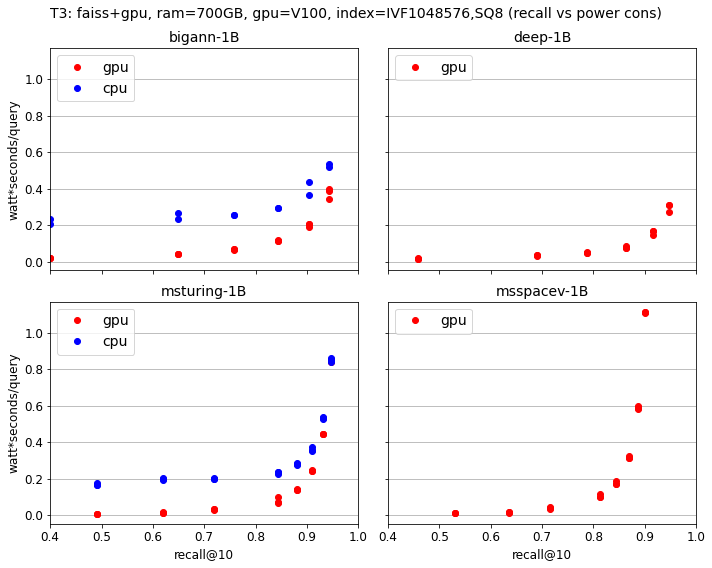

In [226]:
# Individual dbase plots
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('axes', labelsize=16, titlesize=16)
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams["figure.titlesize"] = 14
plt.rcParams["figure.titleweight"] = 'roman'
#print(plt.rcParams.keys())

fig, axs = plt.subplots(2,2, sharey=True, sharex=True)

for d, idx in enumerate(expdata.keys()):
        
    for i,exp in enumerate(expdata[idx]['data']):
        recall = exp[0]
        qps = exp[1]
        wspq = exp[2]
        
        gpu_only=True
        gpu = expdata[idx]['gpu']
        if gpu[i]==1: 
            color = 'red'
        else: 
            gpu_only=False
            color='blue'  

        if d==0: 
            ax = axs[0,0]
            ax.set_ylabel("watt*seconds/query")
        elif d==1: 
            ax = axs[0,1] 
        elif d==2:    
            ax = axs[1,0]      
            ax.set_ylabel("watt*seconds/query")
            ax.set_xlabel("recall@10")
        elif d==3: 
            ax = axs[1,1]
            ax.set_xlabel("recall@10")
       
        shape = ax.plot(recall, wspq, '.', markersize=12, color=color)
        #ax.set_yscale('log')
        #ax.set_ylim([500,100000])
        #ax.set_yticks([1000,10000,100000])
        ax.set_xlim([0.4,1.0])
        ax.set_xticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
           
        if gpu[i]:
            gpu_shape = shape[0]
        else:
            cpu_shape = shape[0]
        
    ax.set_title(idx.replace("-T3","")) 
    ax.grid(axis = 'y')
    if gpu_only:
        ax.legend([gpu_shape,],['gpu',],loc='upper left', fontsize=14)
    else:
        ax.legend([gpu_shape, cpu_shape],['gpu','cpu'],loc='upper left', fontsize=14)
 
    plt.suptitle('T3: faiss+gpu, ram=700GB, gpu=V100, index=IVF1048576,SQ8 (recall vs power cons)')
   
plt.tight_layout()
plt.show()
fig.patch.set_alpha(1)
fig.savefig("recall_vs_wspq.png",facecolor=fig.get_facecolor(), edgecolor='none', transparent=False)

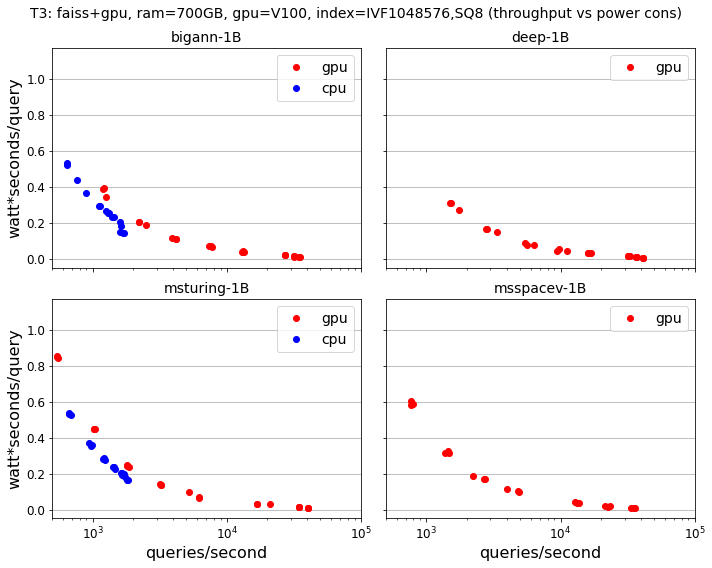

In [227]:
# Individual dbase plots
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('axes', labelsize=16, titlesize=16)
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams["figure.titlesize"] = 14
plt.rcParams["figure.titleweight"] = 'roman'
#print(plt.rcParams.keys())

fig, axs = plt.subplots(2,2, sharey=True, sharex=True)

for d, idx in enumerate(expdata.keys()):
        
    for i,exp in enumerate(expdata[idx]['data']):
        recall = exp[0]
        qps = exp[1]
        wspq = exp[2]
        
        gpu_only=True
        gpu = expdata[idx]['gpu']
        if gpu[i]==1: 
            color = 'red'
        else: 
            gpu_only=False
            color='blue'  

        if d==0: 
            ax = axs[0,0]
            ax.set_ylabel("watt*seconds/query")
        elif d==1: 
            ax = axs[0,1] 
        elif d==2:    
            ax = axs[1,0]      
            ax.set_ylabel("watt*seconds/query")
            ax.set_xlabel("queries/second")
        elif d==3: 
            ax = axs[1,1]
            ax.set_xlabel("queries/second")
       
        shape = ax.plot(qps, wspq, '.', markersize=12, color=color)
        ax.set_xscale('log')
        ax.set_xlim([500,100000])
        ax.set_xticks([1000,10000,100000])
        #ax.set_xlim([0.4,1.0])
        #ax.set_xticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
           
        if gpu[i]:
            gpu_shape = shape[0]
        else:
            cpu_shape = shape[0]
        
    ax.set_title(idx.replace("-T3","")) 
    ax.grid(axis = 'y')
    if gpu_only:
        ax.legend([gpu_shape,],['gpu',],loc='upper right', fontsize=14)
    else:
        ax.legend([gpu_shape, cpu_shape],['gpu','cpu'],loc='upper right', fontsize=14)
 
    plt.suptitle('T3: faiss+gpu, ram=700GB, gpu=V100, index=IVF1048576,SQ8 (throughput vs power cons)')
   
plt.tight_layout()
plt.show()
fig.patch.set_alpha(1)
fig.savefig("throughput_vs_wspq.png",facecolor=fig.get_facecolor(), edgecolor='none', transparent=False)